## Desperately seeking silver 

Well in this project, I'll be predicting election results but with some sophisticated techniques... just for fun! 

The data is from 2012 presidential elections. Analysts like Nate Silver, Drew Linzer, and Sam Wang developed highly accurate models that correctly forecasted most or all of the election outcomes in each of the 50 states.

**Steps**
1. First I'll try to simulate the model using the model given in the data..i.e. the probabilities given
2. Then I'll try to make my own model using the poll data prior to elections
        - first building a simple model, 0-1 model
        - including uncertainity
        - then taking in count of the bias (predicting bias using the historical data)

#### Setup and plotting code

In [1]:
%matplotlib inline 

from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#for changing the size of the plots 
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    #gca = get current axis 
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)        

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [3]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)
data = json.load(open("data/us-states.json", "r"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    #these are the border coordinates which we'll plot!
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)
            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)
        

def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax        

In [4]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

### Background: The Electoral College

US Presidential elections revolve around the Electoral College . In this system, each state receives a number of Electoral College votes depending on it's population -- there are 538 votes in total. In most states, all of the electoral college votes are awarded to the presidential candidate who recieves the most votes in that state. A candidate needs 269 votes to be elected President.

Thus, to calculate the total number of votes a candidate gets in the election, we add the electoral college votes in the states that he or she wins. (This is not entirely true, with Nebraska and Maine splitting their electoral college votes, but, for the purposes of this homework, we shall assume that the winner of the most votes in Maine and Nebraska gets ALL the electoral college votes there.)

Here is the electoral vote breakdown by state:

In [5]:
electoral_votes = pd.read_csv("data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


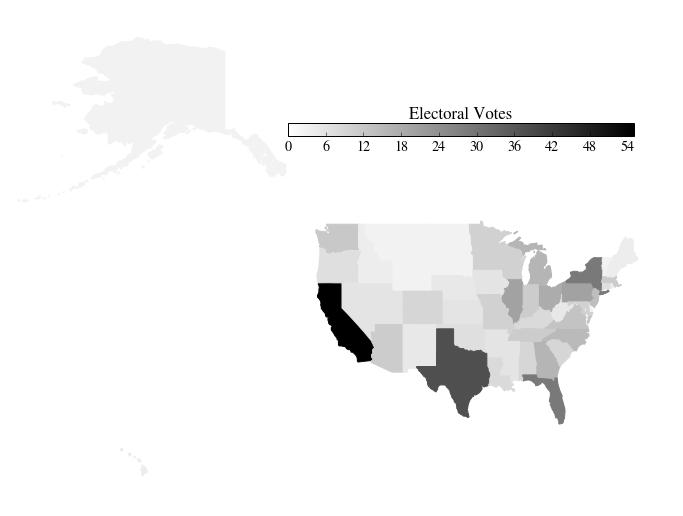

In [7]:
make_map(electoral_votes.Votes, "Electoral Votes");

## Simulating Elections 

In [12]:
predictwise = pd.read_csv('data/predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


Each row is the probability predicted by Predictwise that Romney or Obama would win a state. The votes column lists the number of electoral college votes in that state. So a chloropeth to see the probability that Obama wins each state.

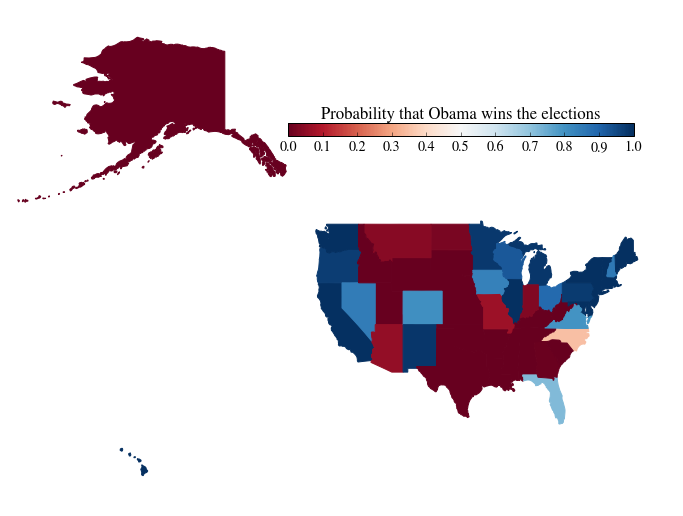

In [13]:
make_map(predictwise.Obama, "Probability that Obama wins the elections")

Later on in this project we will explore some approaches to estimating probabilities like these and quatifying our uncertainty about them. But for the time being, we will focus on how to make a prediction assuming these probabilities are known.

Even when we assume the win probabilities in each state are known, there is still uncertainty left in the election. We will use simulations from a simple probabilistic model to characterize this uncertainty. From these simulations, we will be able to make a prediction about the expected outcome of the election, and make a statement about how sure we are about it.

Now the outcome of each state can be thought an independent coin flip whose probabilty of coming up Obama is given in the dataframe i.e. a biased coin.

In [209]:
def simulate_election(Obama_dataframe, nsim):
        simulations = np.random.uniform(size = (51, nsim))
        results = (simulations < Obama_dataframe.Obama.values.reshape(-1, 1)) * Obama_dataframe.Votes.values.reshape(-1, 1)
        #axis = 0 means sum along the column
        return results.sum(axis = 0) 

In [210]:
result = simulate_election(predictwise, 10000)

In [211]:
Obama_wins = sum(1 for n in result if n >=269)
print (Obama_wins / 10000)
# we can do 
#(result >= 269).mean()

0.9963


In [212]:
def plot_simulation(predic):
    plt.hist(predic, bins = np.arange(200, 530, 1), label = "Simulations", align = 'left', normed = "True")
    plt.axvline(269, 0, .5, color = 'k', label = 'Victory Threshhold')
    plt.axvline(332, 0, .5, color = 'r', label = 'Actual Outcome')
    p05 = np.percentile(predic, 5.)
    p95 = np.percentile(predic, 95.)    
    print (p05, p95)
    iq = int(p95 - p05)
    res = (predic >= 269).mean() * 100
    plt.title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (res, iq))
    plt.legend(frameon = False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    remove_border()

287.0 347.0


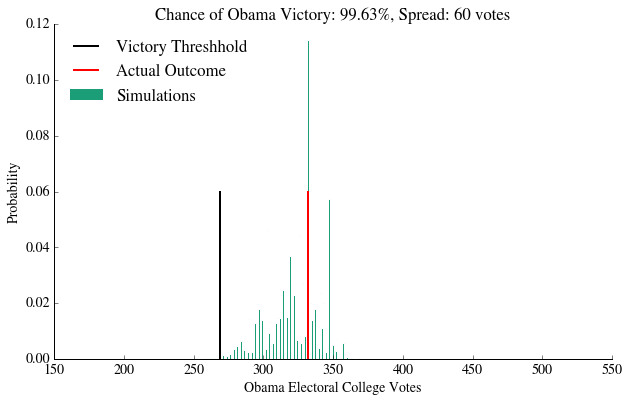

In [213]:
plot_simulation(result)

### Evaluating and Validating our Forecast

The point of creating a probabilistic predictive model is to simultaneously make a forecast and give an estimate of how certain we are about it.

However, in order to trust our prediction or our reported level of uncertainty, the model needs to be correct. We say a model is correct if it honestly accounts for all of the mechanisms of variation in the system we're forecasting.

In this section, we evaluate our prediction to get a sense of how useful it is, and we validate the predictive model by comparing it to real data.

*Accuracy refers to the closeness of a measured value to a standard or known value. For example, if in lab you obtain a weight measurement of 3.2 kg for a given substance, but the actual or known weight is 10 kg, then your measurement is not accurate. In this case, your measurement is not close to the known value.*

*Precision refers to the closeness of two or more measurements to each other. Using the example above, if you weigh a given substance five times, and get 3.2 kg each time, then your measurement is very precise. Precision is independent of accuracy. You can be very precise but inaccurate, as described above. You can also be accurate but imprecise.*

The accuracy of the model is really nice as according to the plot we can see that most of the data is lying around 332.

The more is the spread in the histogram, the less is the precision. Because we are assuming the model is correct, we can interpret the spread of the histogram as a measure of the variability among the election outcomes that are consistent with the information we have. If our current information does not constrain the likely election outcomes very much, then the difference between our prediction and the true outcome can vary widely. The spread of the histogram is 60 votes, which is relatively large. Whether the prediction is precise enough is a question of what you want to do with your prediction. For example, if you want to be able to call the winner of a close election (say the candidates are separated by less than 30 votes), this prediction would not be precise enough to identify a winner with 95% confidence. To handle this, we might wish to incorporate more information into the model to reduce the spread of likely election outcomes.

#### So to be sure of the outcome, one of our motive is to reduce the spread too.

Unfortunately, we can never be absolutely sure that a model is correct, just as we can never be absolutely sure that the sun will rise tomorrow. But we can test a model by making predictions assuming that it is true and comparing it to real events -- this constitutes a hypothesis test. After testing a large number of predictions, if we find no evidence that says the model is wrong, we can have some degree of confidence that the model is right (the same reason we're still quite confident about the sun being here tomorrow). We call this process model checking, and use it to validate our model.

The graph above also shows a hypothesis test... based on the predictions loaded from the csv file. The histogram approximates the predictive distribution of election outcomes (in terms of electoral votes) assuming our model for the election is true. By comparing this to the true outcome of the election, we can see whether the observed electoral vote count would be highly atypical if the model were true. In this case, it appears the true outcome is quite typical among the model's predicted outcomes, so we do not reject our model.

In this case, we have checked only one prediction, since there is only one true outcome that we've compared to the predictive distribution.

To increase our confidence, we would want to test more outcomes against predictions that were made in the same way. For example, we could apply the same procedure (including PredictWise's computation of the statewise probability estimates) to different elections and see whether each of the hypothesis tests fails to reject the model in those cases as well. We could also break the election down into state-by-state outcomes, and test the prediction for each state against that state's outcome.

## Gallup Party Affiliation Poll

Now we will try to estimate our own win probabilities to plug into our predictive model.

We will start with a simple forecast model. We will try to predict the outcome of the election based the estimated proportion of people in each state who identify with one one political party or the other.

Gallup measures the political leaning of each state, based on asking random people which party they identify or affiliate with. Here's the data they collected from January-June of 2012:

In [261]:
#predictions are based on THIS DATA ONLY
gallup_2012=pd.read_csv("data/g12.csv").set_index('State')
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


In [262]:
def simple_gallup_model(gallup):
    return pd.DataFrame(dict(Obama=(gallup.Dem_Adv > 0).astype(float)))

334.0 334.0


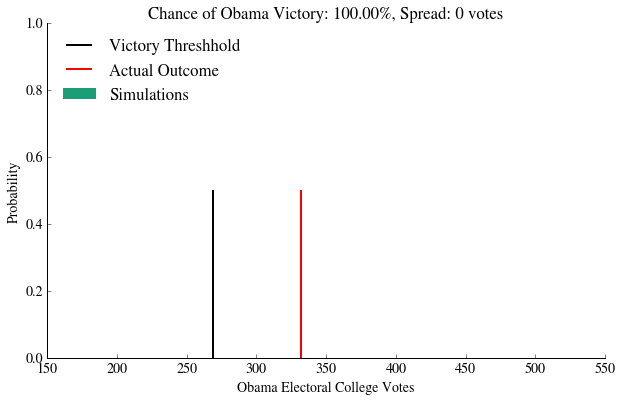

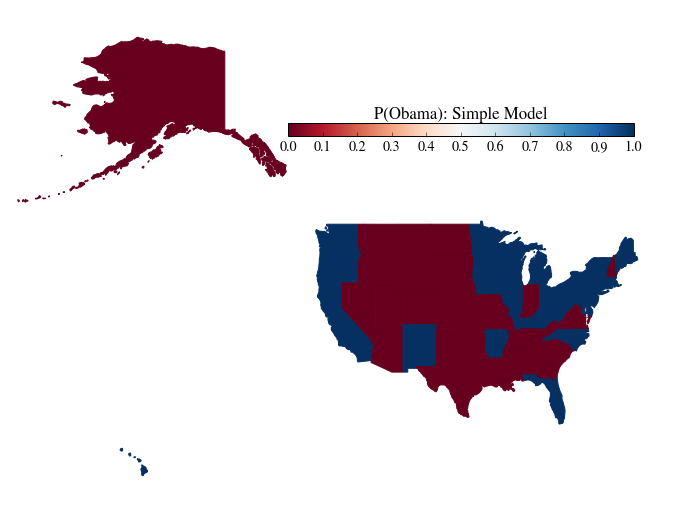

In [263]:
model = simple_gallup_model(gallup_2012)
#add the votes Column in the model so that we can run the simulation with our own model of predictions!
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)
plt.show()
make_map(model.Obama, "P(Obama): Simple Model")

We do not predict the exactly correct result (red line). According to the predictive model, the true outcome has probability 0. Thus, the evidence contradicts the predictive model, and we should reject it.

#### Uncertainity is if we keep on drawing samples from the population how will it make a difference (also called variance), on the other hand bias is something which occurs because of systematic errors as shown further. It is taken account in the final probability, where as here we took account of the bias while collecting the data.

###### The model above is brittle -- it includes no accounting for uncertainty, and thus makes predictions with 100% confidence. This is clearly wrong -- there are numerous sources of uncertainty in estimating election outcomes from a poll of affiliations.

The most obvious source of error in the Gallup data is the finite sample size -- Gallup did not poll everybody in America, and thus the party affilitions are subject to sampling errors. How much uncertainty does this introduce?

On their webpage discussing these data, Gallup notes that the sampling error for the states is between 3 and 6%, with it being 3% for most states. (The calculation of the sampling error itself is an exercise in statistics. Its fun to think of how you could arrive at the sampling error if it was not given to you. One way to do it would be to assume this was a two-choice situation and use binomial sampling error for the non-unknown answers, and further model the error for those who answered 'Unknown'.)

Now as our sample size is large enough, according to the c.l.t.(central limit theorem) the distribution can be approximated as normal distribution, so we can use cdf to estimate the probability of Obama winning the election, using Dem_Adv as the deflection and 3 as the standard deviation.

In [264]:
from scipy.special import erf
def uncertain_gallup_model(gallup):
    sigma = 3
    #something negative will lead to less probablility 
    diff = .5*(1 + erf((gallup.Dem_Adv) / np.sqrt(2 * sigma ** 2)))
    return pd.DataFrame(dict(Obama = diff), index = gallup.index)
uncertain_gallup_model(gallup_2012).head()

,Obama
State,
Alabama,0.000003
Alaska,0.002555
Arizona,0.006210
Arkansas,0.592249
California,0.999998


274.0 343.0


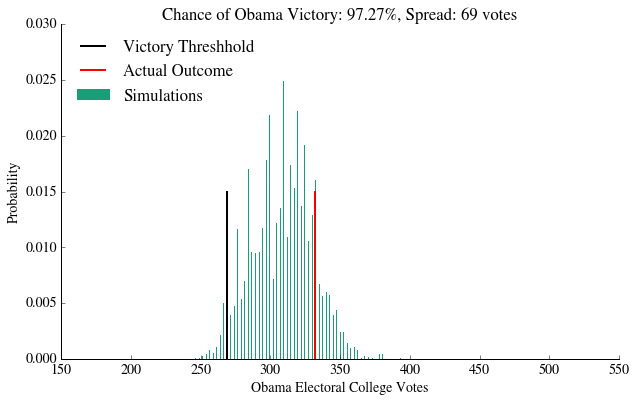

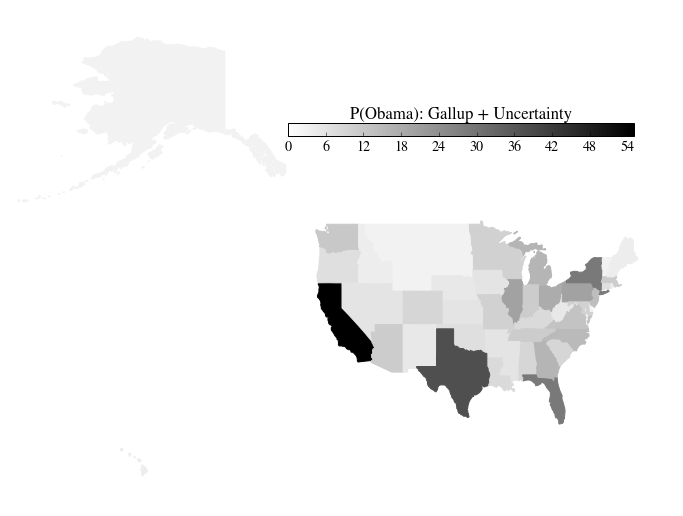

In [265]:
model = uncertain_gallup_model(gallup_2012)
model = model.join(electoral_votes)
simu = simulate_election(model, 10000)
plot_simulation(simu)
make_map(model.Votes, "P(Obama): Gallup + Uncertainty")

The predictive distribution is consistent with the real data -- the real outcome seems like a typical outcome according to the model. The accuracy is not very good as the center of the distribution falls fairly far from the observed outcome, but the precision is only marginally worse than in the predictwise case.

**Biases**

While accounting for uncertainty is one important part of making predictions, we also want to avoid systematic errors. We call systematic over- or under-estimation of an unknown quantity bias. In the case of this forecast, our predictions would be biased if the estimates from this poll systematically over- or under-estimate vote proportions on election day. There are several reasons this might happen:

1. Gallup is wrong. The poll may systematically over- or under-estimate party affiliation. This could happen if the people who answer Gallup phone interviews might not be a representative sample of people who actually vote, Gallup's methodology is flawed, or if people lie during a Gallup poll.
2. Our assumption about party affiliation is wrong. Party affiliation may systematically over- or under-estimate vote proportions. This could happen if people identify with one party, but strongly prefer the candidate from the other party, or if undecided voters do not end up splitting evenly between Democrats and Republicans on election day.
3. Our assumption about equilibrium is wrong. This poll was released in August, with more than two months left for the elections. If there is a trend in the way people change their affiliations during this time period (for example, because one candidate is much worse at televised debates), an estimate in August could systematically miss the true value in November.

One way to account for bias is to calibrate our model by estimating the bias and adjusting for it. Before we do this, let's explore how sensitive our prediction is to bias.

In [276]:
def biased_gallup_poll(gallup, bias):
    gallup_2 = gallup.copy()
    gallup_2.Dem_Adv = gallup_2.Dem_Adv - bias
    return gallup_2

258.0 328.0


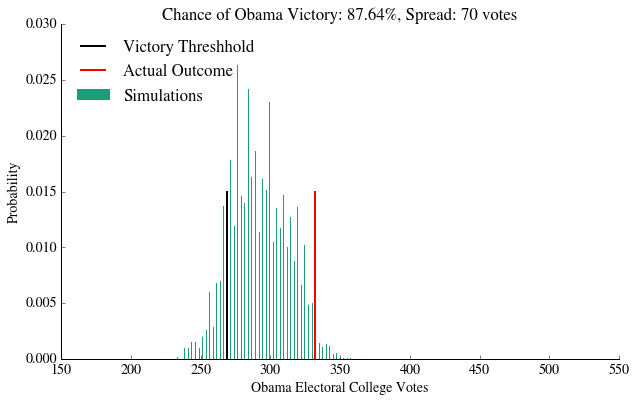

208.0 264.0


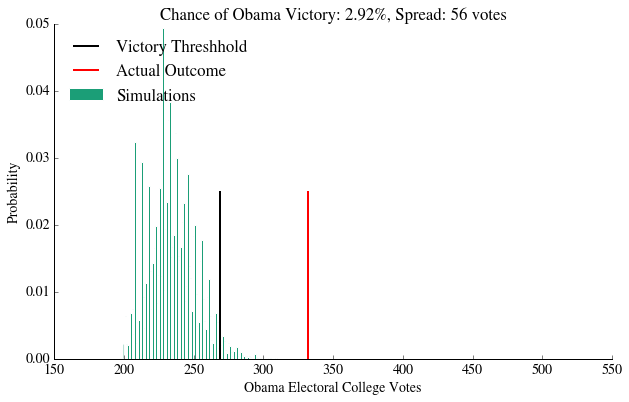

In [278]:
biased_gallup_1 = biased_gallup_poll(gallup_2012, 1)
model = uncertain_gallup_model(biased_gallup_1)
model = model.join(electoral_votes)
simulate = simulate_election(model, 10000)
plot_simulation(simulate)
plt.show()

biased_gallup_2 = biased_gallup_poll(gallup_2012, 5)
model = uncertain_gallup_model(biased_gallup_2)
model = model.join(electoral_votes)
simulate = simulate_election(model, 10000)
plot_simulation(simulate)
plt.show()

(Uncertainity can be calculated using bootstrapping and bias can be calculated using historical data)

**Estimating the size of the bias from the 2008 election**

While bias can lead to serious inaccuracy in our predictions, it is fairly easy to correct if we are able to estimate the size of the bias and adjust for it. This is one form of calibration.

One approach to calibrating a model is to use historical data to estimate the bias of a prediction model. We can use our same prediction model on historical data and compare our historical predictions to what actually occurred and see if, on average, the predictions missed the truth by a certain amount. Under some assumptions (discussed in a question below), we can use the estimate of the bias to adjust our current forecast.

In this case, we can use data from the 2008 election. (The Gallup data from 2008 are from the whole of 2008, including after the election):

In [344]:
gallup_08 = pd.read_csv("data/g08.csv").set_index('State')
results_08 = pd.read_csv('data/2008results.csv').set_index('State')

#if only single brackets are used it'll consider it a pandas series rather than a dataframe
prediction_08 = gallup_08[['Dem_Adv']]
prediction_08['Dem_Win']=results_08["Obama Pct"] - results_08["McCain Pct"]
prediction_08.head()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Dem_Adv,Dem_Win
State,,
Alabama,-0.8,-21.58
Alaska,-10.6,-21.53
Arizona,-0.4,-8.52
Arkansas,12.5,-19.86
California,19.4,24.06


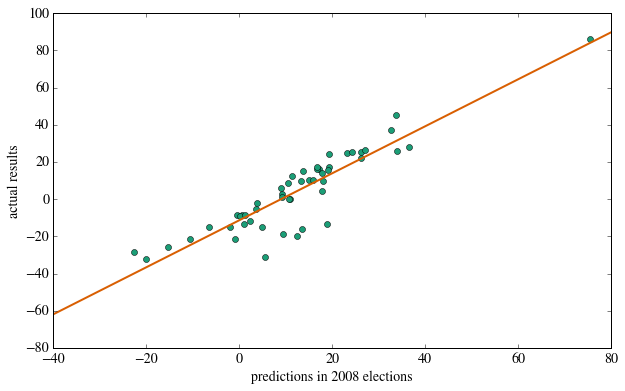

In [327]:
plt.plot(prediction_08.Dem_Adv, prediction_08.Dem_Win, 'o')
plt.xlabel("predictions in 2008 elections")
plt.ylabel("actual results")
fit = np.polyfit(prediction_08.Dem_Adv, prediction_08.Dem_Win, 1)
x = np.linspace(-40, 80, 10)
y = np.polyval(fit, x)
plt.plot(x, y)
#take exor of both to check the sign
#plotting where the result failed
failed_pred = pd.DataFrame(dict(failed = ((prediction_08.Dem_Adv < 0) ^ (prediction_08.Dem_Win > 0)).astype(float)), index = prediction_08.index)

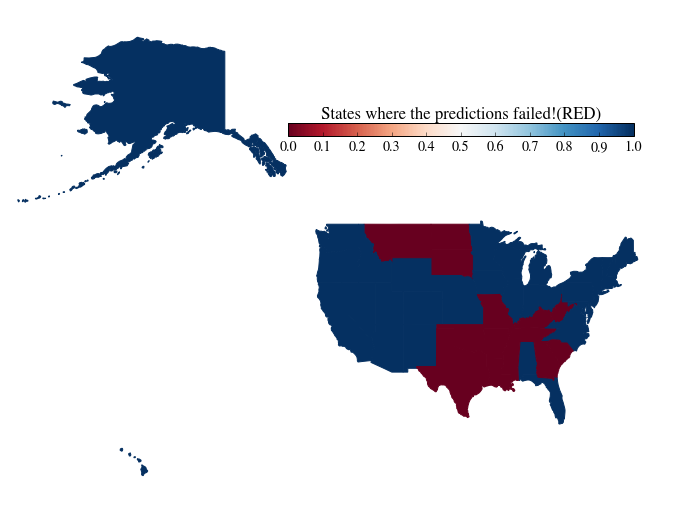

In [325]:
make_map(failed_pred.failed, "States where the predictions failed!(RED)")

In [321]:
name_of_states_predfailed = prediction_08[((prediction_08.Dem_Adv > 0) & (prediction_08.Dem_Win < 0))].index
name_of_states_predfailed

Index(['Arkansas', 'Georgia', 'Kentucky', 'Louisiana', 'Mississippi', 'Missouri', 'Montana', 'North Dakota', 'Oklahoma', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'West Virginia'], dtype='object', name='State')

In [329]:
print ((prediction_08.Dem_Adv - prediction_08.Dem_Win).mean())

8.06803921569


The bias was roughly 8% in favor of the Democrats in the Gallup Poll, meaning that you would want to adjust predictions based on this poll down by that amount. This was the result of people in a number of Southern and Western states claiming to be affiliated as Democrats, then voting the other way. Or, since Gallup kept polling even after the elections, it could also represent people swept away by the 2008 election euphoria in those states. This is an illustration of why one needs to be carefull with polls.

168.0 226.0


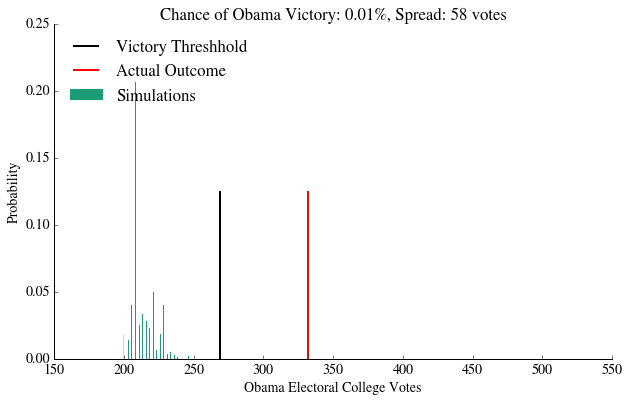

In [331]:
biased = biased_gallup_poll(gallup_2012, 8.06)
model = uncertain_gallup_model(biased)
model = model.join(electoral_votes)
predictions = simulate_election(model, 10000)
plot_simulation(predictions)

This was a disaster. The 8% calibration completey destroys the accuracy of our prediction in 2012. Our calibration made the assumptions that 

a) the bias in 2008 was the same as 2012, and 

b) the bias in each state was the same.

### Logistic considerations

In this section, we use a more sophisticated approach to link side information -- usually called features or predictors -- to our prediction. This approach has several advantages, including the fact that we may use multiple features to perform our predictions. Such data may include demographic data, exit poll data, and data from previous elections.

#### The Partisan Voting Index

The Partisan Voting Index (PVI) is defined as the excessive swing towards a party in the previous election in a given state.

In [334]:
#these are the final results of 2004-2012
national_results=pd.read_csv("data/nat.csv")
national_results.set_index('Year',inplace=True)
national_results

,Dem,Rep
Year,,
2004,48,51
2008,53,46
2012,51,47


Let us also load in data about the 2004 elections from p04.csv which gets the results in the above form for the 2004 election for each state.

In [339]:
polls04=pd.read_csv("data/p04.csv")
polls04.State=polls04.State.replace(states_abbrev)
polls04.set_index("State", inplace = True)
polls04.head()

,Dem,Rep
State,,
Alabama,37,63
Alaska,34,62
Arizona,44,55
Arkansas,45,54
California,54,45


In [342]:
pvi08 = (polls04.Dem - polls04.Rep) - (national_results.xs(2004)['Dem'] - national_results.xs(2004)['Rep'])
pvi08.head()

State
Alabama      -23
Alaska       -25
Arizona       -8
Arkansas      -6
California    12
dtype: int64

In [349]:
e2008 = pd.DataFrame(dict(pvi = pvi08, Dem_Adv = prediction_08.Dem_Adv - prediction_08.Dem_Adv.mean(), 
                         obama_win = (prediction_08.Dem_Win > 0).astype(int), Dem_Win = prediction_08.Dem_Win)
                     , index = polls04.index)

In [350]:
e2008.head()

,Dem_Adv,Dem_Win,obama_win,pvi
State,,,,
Alabama,-13.154902,-21.58,0,-23
Alaska,-22.954902,-21.53,0,-25
Arizona,-12.754902,-8.52,0,-8
Arkansas,0.145098,-19.86,0,-6
California,7.045098,24.06,1,12


In [351]:
pvi12 = e2008.Dem_Win - (national_results.xs(2008)['Dem'] - national_results.xs(2008)['Rep'])
e2012 = pd.DataFrame(dict(pvi=pvi12, Dem_Adv=gallup_2012.Dem_Adv - gallup_2012.Dem_Adv.mean()))
e2012 = e2012.sort_index()
e2012.head()

,Dem_Adv,pvi
State,,
Alabama,-14.684314,-28.58
Alaska,-9.484314,-28.53
Arizona,-8.584314,-15.52
Arkansas,-0.384314,-26.86
California,12.615686,17.06


In [352]:
#these are the actual results of 2012! Finally here!
results2012 = pd.read_csv("data/2012results.csv")
results2012.set_index("State", inplace=True)
results2012 = results2012.sort_index()
results2012.head()

,Winner
State,
Alabama,0
Alaska,0
Arizona,0
Arkansas,0
California,1


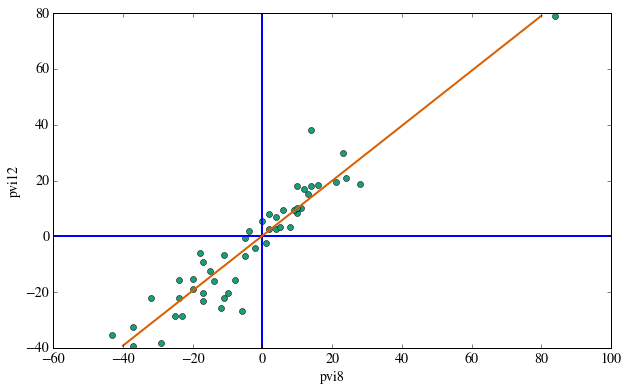

In [356]:
plt.plot(pvi08, pvi12, 'o')
plt.axvline(0)
plt.axhline(0)
plt.xlabel("pvi8")
plt.ylabel("pvi12")
fit = np.polyfit(pvi08, pvi12, 1)
x = np.linspace(-40, 80, 10)
y = np.polyval(fit, x)
plt.plot(x, y)

Theres lot to observe in this plot! First of all we see there are hardly any datapoints which differ in size, which directly tells us that the pvi is kind of remainging the same in both the years. 
